# Read eccentricity from posterior/convert to uniform definition

This notebook has one step:
 - 1.) Read the posterior samples, generate EOB waveforms for each sample.
 
What this notebook is currently missing:
 - a) Measure eccentricity from the injected NR waveform at a particular frequency/time using the methods implemented in the repository.
 - b) Convert the eccentricity posterior to a uniform definition, and output this to a posterior file. 

 

# 1) Measure eccentricity from the injected NR waveform 

In [12]:
import os, sys, glob

#sys.path.append(os.environ['WAVEFORM_TOOLS_PATH'])

import numpy as np
import h5py
import lal, lalsimulation as lalsim
import matplotlib.pyplot as plt 

#from utils_convert_posteriors import *
def SectotimeM(seconds, M):
    return seconds/(M*lal.MTSUN_SI)


def AmpPhysicaltoNRTD(ampphysical, M, dMpc):
    return ampphysical*dMpc*1e6*lal.PC_SI/(lal.C_SI*(M*lal.MTSUN_SI))

from scipy.interpolate import InterpolatedUnivariateSpline

def SEOBNRv4EHM_modes(q: float, chi1: float,chi2: float, eccentricity: float, eccentric_anomaly: float,
                      f_min:float, dMpc: float, M_fed:float, delta_t: float, EccIC: int, approx: str):


    HypPphi0, HypR0, HypE0 =[0.,0,0]


    EccFphiPNorder = 99
    EccFrPNorder = 99
    EccWaveformPNorder = 16
    EccBeta = 0.09
    Ecct0 = 100

    EccPNFactorizedForm = EccNQCWaveform =EccPNRRForm = EccPNWfForm =EccAvNQCWaveform=1
    EcctAppend=40
    #EccIC=0
    #eccentric_anomaly = 0.0

    m1= q/(1+q)*M_fed
    m2= 1/(1+q)*M_fed
    dist = dMpc*(1e6*lal.PC_SI)

    if approx=="SEOBNRv4E_opt"  or approx=="SEOBNRv4E_opt1" or  approx=="SEOBNRv4":
        mode_list=[[2,2]]

        SpinAlignedVersion=4
        nqcCoeffsInput=lal.CreateREAL8Vector(10) ##This will be unused, but it is necessary

    else:
        mode_list=[[2,2]]

        SpinAlignedVersion=41
        nqcCoeffsInput=lal.CreateREAL8Vector(50) ##This will be unused, but it is necessary

    if approx == "SEOBNRv4E_opt" or approx == "SEOBNRv4EHM_opt":

        sphtseries, dyn, dynHi = lalsim.SimIMRSpinAlignedEOBModesEcc_opt(delta_t,
                                                              m1*lal.MSUN_SI,
                                                              m2*lal.MSUN_SI,
                                                              f_min,
                                                              dist,
                                                              chi1,
                                                              chi2,
                                                              eccentricity,
                                                              eccentric_anomaly,
                                                              SpinAlignedVersion, 0., 0., 0.,0.,0.,0.,0.,0.,1.,1.,
                                                              nqcCoeffsInput, 0,
                                                              EccFphiPNorder,EccFrPNorder, EccWaveformPNorder,
                                                              EccPNFactorizedForm, EccBeta, Ecct0, EccNQCWaveform,
                                                              EccPNRRForm, EccPNWfForm, EccAvNQCWaveform,
                                                              EcctAppend,EccIC,HypPphi0, HypR0, HypE0)

    elif approx == "SEOBNRv4E_opt1" or approx == "SEOBNRv4EHM_opt1":

        sphtseries, dyn, dynHi = lalsim.SimIMRSpinAlignedEOBModesEcc_opt1(delta_t,
                                                              m1*lal.MSUN_SI,
                                                              m2*lal.MSUN_SI,
                                                              f_min,
                                                              dist,
                                                              chi1,
                                                              chi2,
                                                              eccentricity,
                                                              eccentric_anomaly,
                                                              SpinAlignedVersion, 0., 0., 0.,0.,0.,0.,0.,0.,1.,1.,
                                                              nqcCoeffsInput, 0,
                                                              EccFphiPNorder,EccFrPNorder, EccWaveformPNorder,
                                                              EccPNFactorizedForm, EccBeta, Ecct0, EccNQCWaveform,
                                                              EccPNRRForm, EccPNWfForm, EccAvNQCWaveform,
                                                              EcctAppend,EccIC,HypPphi0, HypR0, HypE0)


    else:


        #print("SEOBNRv4HM modes")
        sphtseries, dyn, dynHi = lalsimul.SimIMRSpinAlignedEOBModes(delta_t,
                                                              m1*lal.MSUN_SI,
                                                              m2*lal.MSUN_SI,
                                                              f_min,
                                                              dist,
                                                              chi1,
                                                              chi2,
                                                              SpinAlignedVersion, 0., 0., 0.,0.,0.,0.,0.,0.,1.,1.,
                                                              nqcCoeffsInput, 0)





    hlm={}


    if SpinAlignedVersion==4:
        hlm[2,2] = AmpPhysicaltoNRTD(sphtseries.mode.data.data,M_fed,dMpc)
        hlm[2,-2] = np.conjugate(hlm[2,2])

    else:
        ##55 mode
        modeL = sphtseries.l
        modeM = sphtseries.m
        h55 = sphtseries.mode.data.data #This is h_55
        #h55LAL = - h55 * np.exp^(-1.j * modeM * phi_ref)
        hlm[modeL,modeM] =  AmpPhysicaltoNRTD(h55 ,M_fed,dMpc)
        hlm[modeL,-modeM] =  ((-1)**modeL) * np.conjugate(hlm[modeL,modeM])

        ##44 mode
        modeL = sphtseries.next.l
        modeM = sphtseries.next.m
        h44 = sphtseries.next.mode.data.data #This is h_44
        hlm[modeL,modeM] =  AmpPhysicaltoNRTD(h44 ,M_fed,dMpc)
        hlm[modeL,-modeM] =  ((-1)**modeL) * np.conjugate(hlm[modeL,modeM])

        ##21 mode
        modeL = sphtseries.next.next.l
        modeM = sphtseries.next.next.m
        h21 = sphtseries.next.next.mode.data.data #This is h_21
        hlm[modeL,modeM] =  AmpPhysicaltoNRTD(h21,M_fed,dMpc)
        hlm[modeL,-modeM] =  ((-1)**modeL) * np.conjugate(hlm[modeL,modeM])

        ##33 mode
        modeL = sphtseries.next.next.next.l
        modeM = sphtseries.next.next.next.m
        h33 = sphtseries.next.next.next.mode.data.data #This is h_33
        hlm[modeL,modeM] =  AmpPhysicaltoNRTD(h33 ,M_fed,dMpc)
        hlm[modeL,-modeM] =  ((-1)**modeL) * np.conjugate(hlm[modeL,modeM])

        ##22 mode
        modeL = sphtseries.next.next.next.next.l
        modeM = sphtseries.next.next.next.next.m
        h22 = sphtseries.next.next.next.next.mode.data.data #This is h_22
        hlm[modeL,modeM] = AmpPhysicaltoNRTD(h22,M_fed,dMpc)
        hlm[modeL,-modeM] =  ((-1)**modeL) * np.conjugate(hlm[modeL,modeM])


    time_array = np.arange(0,len(hlm[2,2])*delta_t, delta_t)
    timeNR = SectotimeM(time_array,M_fed)

    lenDyn = int(dyn.length/5)

    tdyn = dyn.data[ 0 : lenDyn]

    #tdyn -=tdyn[-1]
    dtDyn = tdyn[1] - tdyn[0]

    rdyn = dyn.data[ lenDyn: 2* lenDyn]
    phidyn = dyn.data[ 2* lenDyn: 3* lenDyn]
    prdyn = dyn.data[ 3* lenDyn: 4* lenDyn]
    pphidyn = dyn.data[ 4* lenDyn: 5* lenDyn]

    iphi = InterpolatedUnivariateSpline(tdyn,phidyn)
    omegaOrbital = iphi.derivative()(tdyn)


    #return time_array, hlm
    omegalm={}; amplm={}; phaselm = {};
    for l,m in mode_list:
        hlm[l,m]=np.conjugate(hlm[l,m]) # Change convention to same as NR

        phaselm[l,m] = -np.unwrap(np.angle(hlm[l,m]))
        iphaselm = InterpolatedUnivariateSpline(timeNR,phaselm[l,m])
        omegalm[l,m]=-iphaselm.derivative()(timeNR)

        amplm[l,m]=np.abs(hlm[l,m])



    imax = np.argmax(amplm[2,2])
    timeNR -= timeNR[imax]

    return timeNR, hlm, amplm, omegalm, phaselm, tdyn, rdyn, phidyn, omegaOrbital, prdyn, pphidyn


In [2]:
# Read a posterior file
import bilby


def result_bilby_file(file):
    return(bilby.result.Result.from_json(file))

# directory where the posterior file lives
post_dir_hyp = '/home/antoniramosbuades/Desktop/EOB_eccentric/PE_injections/conversion_eMeanAnoPosteriors/test_posterior/'

In [4]:
label = '1359'

merged_files = sorted(glob.glob(post_dir_hyp +'/*merge*json'))
merged_files

['/home/antoniramosbuades/Desktop/EOB_eccentric/PE_injections/conversion_eMeanAnoPosteriors/test_posterior/v4E_SXS_1359_Mtot_70_TDPmarg_meanAno_nact10_nlive2048_merged_result.json']

In [69]:
## Choose one posterior file
ii=0

# Read result file and store it in a dict
PB_dict = {}

basename = os.path.basename(merged_files[ii]).split('_merged_result.json')[0]
PB_dict[basename] = result_bilby_file(merged_files[ii])



metadata = PB_dict[basename].meta_data

f_min = metadata['likelihood']['waveform_arguments']['reference_frequency']
srate = metadata['likelihood']['sampling_frequency']

print(f"f_min = {f_min}, srate = {srate}")

# Compute the actual posterior file
posteriors = PB_dict[basename].posterior


chi1_posterior = np.array(posteriors["chi_1"])
chi2_posterior = np.array(posteriors["chi_2"])
ecc_posterior = np.array(posteriors["eccentricity"])
meanAno_posterior = np.array(posteriors["mean_anomaly"])

mtotal_posterior = np.array(posteriors["total_mass"])
q_posterior = np.array(posteriors["mass_ratio"])

q_posterior = 1./q_posterior
dMpc_posterior = np.array(posteriors['luminosity_distance'])

delta_t = 1./srate
EccIC = -1 # generic point in the orbit

f_min = 20.0, srate = 4096.0


In [70]:
# Generate 1 sample
jj = 5001


approx = 'SEOBNRv4E_opt'

# Generate model 22-mode amplitude and frequency 

print(f"q = {q_posterior[jj]}, chi1 = {chi1_posterior[jj]}, chi2 = {chi2_posterior[jj]},\
      ecc = {ecc_posterior[jj]}, meanAno = {meanAno_posterior[jj]}, fmin = {f_min},\
      dMpc = {dMpc_posterior[jj]}, Mtotal ={mtotal_posterior[jj]}")

timeNR, hlm, amplm, omegalm, phaselm,tdyn,\
rdyn, phidyn, omegaOrbital, prdyn, pphidyn= SEOBNRv4EHM_modes(q_posterior[jj],
                                                         chi1_posterior[jj],
                                                         chi2_posterior[jj],
                                                         ecc_posterior[jj],
                                                         meanAno_posterior[jj],
                                                         f_min, 
                                                         dMpc_posterior[jj],
                                                         mtotal_posterior[jj],
                                                         delta_t, EccIC, approx)



q = 1.8934155510795985, chi1 = 0.1054065987898591, chi2 = 0.10383477274579535,      ecc = 0.11876334286590932, meanAno = 2.191029792846097, fmin = 20.0,      dMpc = 1766.4187670387214, Mtotal =72.35571644974793


/home/antoniramosbuades/opt/miniconda3/envs/lalv4E_wftools/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


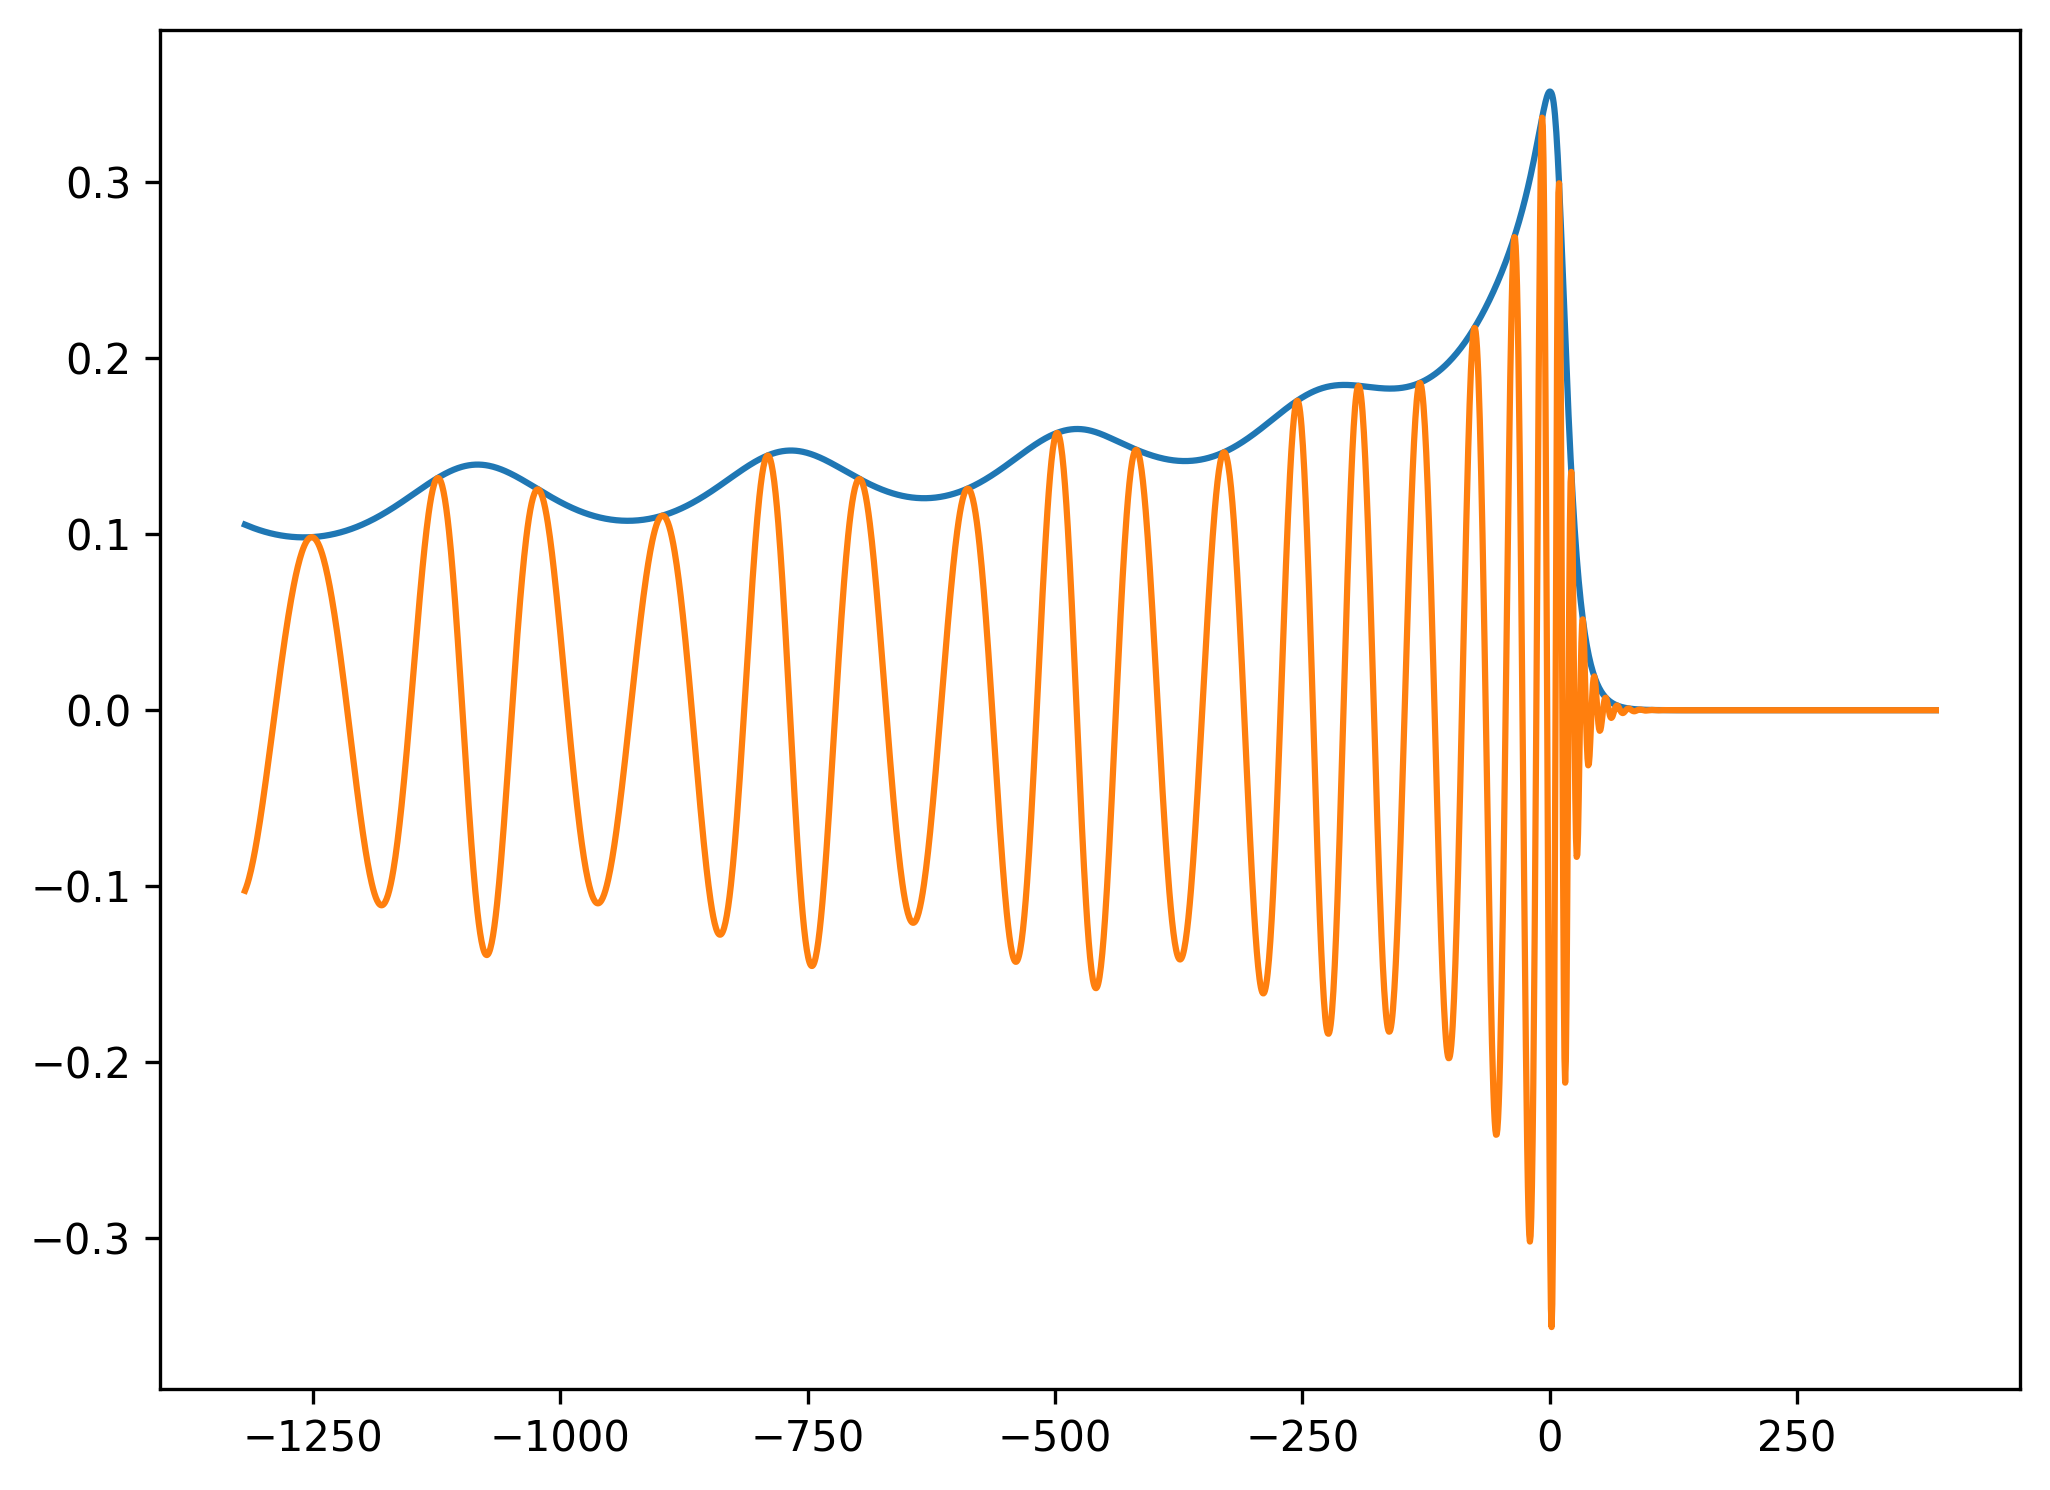

In [71]:

plt.figure(figsize=(8, 6), dpi=300)

plt.plot(timeNR,amplm[2,2])
plt.plot(timeNR,hlm[2,2])
#plt.plot(timeNR,omegalm[2,2])


plt.show()

In [72]:
# TODO:
# 1) Apply one of the methods from the repo to compute (ew22ref,lref)
# 2) Loop over samples
# 3) Output all the samples for (ew22ref,lref) to another json file